In [4]:
%load_ext cudf.pandas

In [5]:
import numpy as np 
import pandas as pd 
from itertools import combinations
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [6]:
train = pd.read_csv("/kaggle/input/playground-series-s5e5/train.csv").set_index('id')
test = pd.read_csv("/kaggle/input/playground-series-s5e5/test.csv").set_index('id')
sample_sub = pd.read_csv("/kaggle/input/playground-series-s5e5/sample_submission.csv")

In [7]:
train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
id,,,,,,,,
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [8]:
test.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
id,,,,,,,
750000,male,45,177.0,81.0,7.0,87.0,39.8
750001,male,26,200.0,97.0,20.0,101.0,40.5
750002,female,29,188.0,85.0,16.0,102.0,40.4
750003,female,39,172.0,73.0,20.0,107.0,40.6
750004,female,30,173.0,67.0,16.0,94.0,40.5


In [9]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   Sex         750000 non-null  object
 1   Age         750000 non-null  int64
 2   Height      750000 non-null  float64
 3   Weight      750000 non-null  float64
 4   Duration    750000 non-null  float64
 5   Heart_Rate  750000 non-null  float64
 6   Body_Temp   750000 non-null  float64
 7   Calories    750000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 52.2+ MB


In [10]:
train.describe()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [11]:
print(train.isnull().sum())
print(test.isnull().sum())

Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
dtype: int64


<Axes: ylabel='count'>

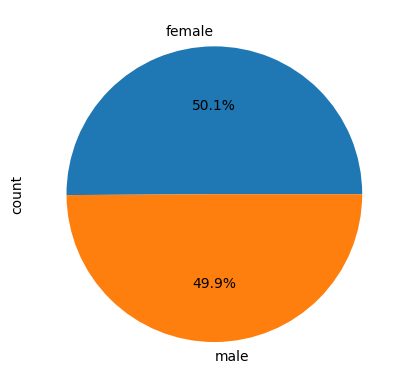

In [12]:
train['Sex'].value_counts().plot(kind='pie',autopct='%1.1f%%' )

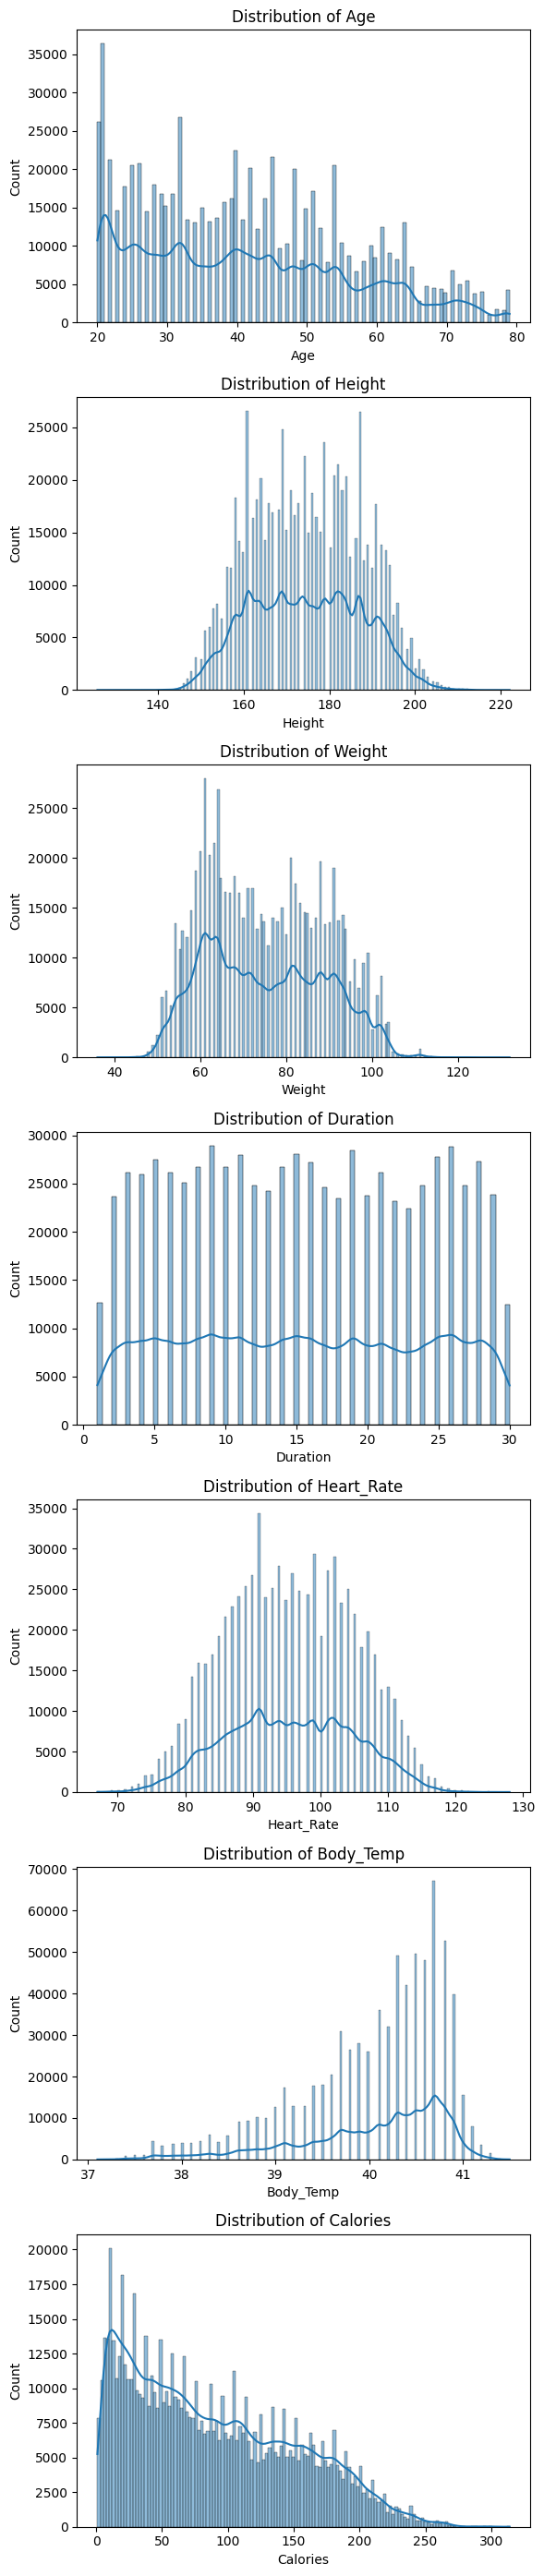

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Select numerical columns
numerical_df = train.select_dtypes(include='number')
num_cols = len(numerical_df.columns)

# Set up the plot grid: vertical (n rows, 1 column)
plt.figure(figsize=(6, 4 * num_cols))  # Adjust height for each plot

# Plot each numerical column vertically
for i, col in enumerate(numerical_df.columns, 1):
    plt.subplot(num_cols, 1, i)
    sns.histplot(numerical_df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()


In [14]:
def engineer_features(df):
    # 1. BMI (Body Mass Index)
    df['BMI'] = df['Weight'] / ((df['Height'] / 100) ** 2)
    
    # 2. Workout Intensity (Heart Rate × Duration)
    df['Workout_Intensity'] = df['Heart_Rate'] * df['Duration']
    
    # 3. Age Group Binning
    df['Age_Group'] = pd.cut(
        df['Age'],
        bins=[0, 20, 35, 50, 65, 100],
        labels=['Teen', 'Young Adult', 'Adult', 'Middle Age', 'Senior']
    )
    
    # 4. Is_Male binary encoding
    df['Is_Male'] = (df['Sex'] == 'male').astype(int)
    
    # 5. Temp Above Normal
    df['Temp_Above_Normal'] = df['Body_Temp'] - 37.0
    
    
    # 7. Heart Rate Zone
    def heart_rate_zone(hr):
        if hr < 90:
            return 'Low'
        elif hr < 120:
            return 'Moderate'
        else:
            return 'High'
    
    df['HR_Zone'] = df['Heart_Rate'].apply(heart_rate_zone)
    
    return df


In [15]:
train = engineer_features(train)
test = engineer_features(test)

In [16]:
train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,Workout_Intensity,Age_Group,Is_Male,Temp_Above_Normal,HR_Zone
id,,,,,,,,,,,,,,
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0,22.955684,2626.0,Adult,1,4.0,Moderate
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0,22.582709,680.0,Middle Age,0,2.7,Low
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0,24.690405,588.0,Middle Age,0,2.8,Low
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0,24.414062,2625.0,Teen,1,3.7,Moderate
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0,22.136740,2550.0,Adult,0,3.6,Moderate


In [17]:
test.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Workout_Intensity,Age_Group,Is_Male,Temp_Above_Normal,HR_Zone
id,,,,,,,,,,,,,
750000,male,45,177.0,81.0,7.0,87.0,39.8,25.854639,609.0,Adult,1,2.8,Low
750001,male,26,200.0,97.0,20.0,101.0,40.5,24.250000,2020.0,Young Adult,1,3.5,Moderate
750002,female,29,188.0,85.0,16.0,102.0,40.4,24.049344,1632.0,Young Adult,0,3.4,Moderate
750003,female,39,172.0,73.0,20.0,107.0,40.6,24.675500,2140.0,Adult,0,3.6,Moderate
750004,female,30,173.0,67.0,16.0,94.0,40.5,22.386314,1504.0,Young Adult,0,3.5,Moderate


In [18]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Sex                750000 non-null  object
 1   Age                750000 non-null  int64
 2   Height             750000 non-null  float64
 3   Weight             750000 non-null  float64
 4   Duration           750000 non-null  float64
 5   Heart_Rate         750000 non-null  float64
 6   Body_Temp          750000 non-null  float64
 7   Calories           750000 non-null  float64
 8   BMI                750000 non-null  float64
 9   Workout_Intensity  750000 non-null  float64
 10  Age_Group          750000 non-null  category
 11  Is_Male            750000 non-null  int64
 12  Temp_Above_Normal  750000 non-null  float64
 13  HR_Zone            750000 non-null  object
dtypes: category(1), float64(9), int64(2), object(2)
memory usage: 83.4+ MB


In [19]:
from sklearn.preprocessing import LabelEncoder

label_cols = ['Sex', 'Age_Group', 'HR_Zone']

for col in label_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])  # assumes all test categories exist in train


In [20]:
def downcast_df(df):
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
        
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
        
    return df


In [21]:
train = downcast_df(train)
test = downcast_df(test)


In [22]:
def add_pairwise_combinations(df, columns=None, operations=['sum', 'diff', 'prod', 'ratio'], row_stats=None):
    """
    Creates pairwise combinations and optional row-wise statistics.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame
        columns (list): Columns to use. If None, all numeric columns except 'Calories'.
        operations (list): Pairwise operations: 'sum', 'diff', 'prod', 'ratio'
        row_stats (list): Row-wise stats to calculate: 'mean', 'std', 'min', 'max', 'median', 'count'

    Returns:
        df (pd.DataFrame): Updated DataFrame
    """
    if columns is None:
        columns = [col for col in df.select_dtypes(include=[np.number]).columns if col != 'Calories']

    # Pairwise combinations
    for col1, col2 in tqdm(combinations(columns, 2), total=len(columns)*(len(columns)-1)//2):
        if 'sum' in operations:
            df[f'{col1}_{col2}_sum'] = df[col1] + df[col2]
        if 'diff' in operations:
            df[f'{col1}_{col2}_diff'] = df[col1] - df[col2]
            df[f'{col2}_{col1}_diff'] = df[col2] - df[col1]
        if 'prod' in operations:
            df[f'{col1}_{col2}_prod'] = df[col1] * df[col2]
        if 'ratio' in operations:
            df[f'{col1}_{col2}_ratio'] = df[col1] / (df[col2] + 1e-6)
            df[f'{col2}_{col1}_ratio'] = df[col2] / (df[col1] + 1e-6)

    # Row-wise statistics
    if row_stats:
        row_data = df[columns]
        if 'mean' in row_stats:
            df['row_mean'] = row_data.mean(axis=1)
        if 'median' in row_stats:
            df['row_median'] = row_data.median(axis=1)
        if 'std' in row_stats:
            df['row_std'] = row_data.std(axis=1)
        if 'min' in row_stats:
            df['row_min'] = row_data.min(axis=1)
        if 'max' in row_stats:
            df['row_max'] = row_data.max(axis=1)
        if 'count' in row_stats:
            df['row_count'] = row_data.count(axis=1)

    return df


In [23]:
train = add_pairwise_combinations(train)
test = add_pairwise_combinations(test)

100%|██████████| 78/78 [00:00<00:00, 143.09it/s]


In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import numpy as np
import optuna

# Custom RMSLE function
def rmsle(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

# Custom RMSLE eval function for XGBoost early stopping
def rmsle_xgb_eval(preds, dtrain):
    labels = dtrain.get_label()
    score = rmsle(labels, preds)
    return 'rmsle', score

# Feature and target
X = train.drop('Calories', axis=1)
y = train['Calories']

# Optuna objective function
def objective(trial):
    params = {
        "tree_method": "hist",
        "enable_categorical": True,
        "device": "cuda",
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.2, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "n_estimators": trial.suggest_int("n_estimators",1000,10000)
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = XGBRegressor(**params)

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric=rmsle_xgb_eval,
            early_stopping_rounds=500,
            verbose=100
        )

        y_pred = model.predict(X_val)
        score = rmsle(y_val, y_pred)
        scores.append(score)

    return np.mean(scores)

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Best results
print("\nBest RMSLE:", study.best_value)
print("Best Parameters:", study.best_params)


[I 2025-05-13 12:02:18,031] A new study created in memory with name: no-name-2a7eccde-9e9b-41c3-a3b0-d0b21590428c
[I 2025-05-13 12:58:55,254] Trial 0 finished with value: 0.060458261519670486 and parameters: {'max_depth': 10, 'colsample_bynode': 0.9187405158935344, 'subsample': 0.970572112323363, 'learning_rate': 0.006110145192496836, 'min_child_weight': 2, 'n_estimators': 5808}. Best is trial 0 with value: 0.060458261519670486.


In [ ]:
test_pred = model.predict(test)
sample_sub['Calories'] = test_pred
sample_sub.to_csv('submission.csv',index = False)
sample_sub.head()